#### rho_d in this code is zeta_d of the paper

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import time
from numba.experimental import jitclass
from numba import double, float32, int32, boolean, typeof
from numba import jit
from numba.types import Tuple, List

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pimg import PBayer
import glob
import json

print(cv2.__version__)
print(np.__version__)
pi = np.pi


4.4.0
1.19.1


#### get AoLP and DoLP from captured image

In [2]:
###############################################################
w = 1224
h = 1024
IMAGE_PATH = '../../../data/sky/out/HDR/ceramic1020/'
CALIB_PATH = '../../../data/sky/calib/'


In [3]:
mask_full = cv2.imread(IMAGE_PATH +'mask_skyarea.png',  cv2.IMREAD_GRAYSCALE).astype(np.float32) /(255-1.0)
mask = mask_full[::2,::2]
# mask_sky_full = cv2.imread(IMAGE_PATH +'mask_sky.png',  cv2.IMREAD_GRAYSCALE).astype(np.float32) /(255-1.0)
# mask_sky = mask_sky_full[::2,::2]

h, w = mask.shape
print(h,w)

# quiver
skipStep=50
pixelPositions_all = np.mgrid[0:w, 0:h].T # h, w, 2
pixelPositions = pixelPositions_all[::skipStep, ::skipStep,:].reshape(-1,2)
pixelU = pixelPositions[:,0] 
pixelV = pixelPositions[:,1]

1024 1224


### function to calculate residual

In [4]:
import mueller
import stokes
# variables : I_d, t_d, I_s, I_zeta,rho_d, phi and theta
# phi : angle between normal projected on yz-plane and y-axis
# theta : angle between normal and x-axis
@jit
def getResidual_init( variables, observed_stokes ,refractive_index, sun_dir, DoLPsmax, skyModelParams,zenith):
    image_num = observed_stokes.shape[0]
    pixel_num = observed_stokes.shape[1]
    
    offset = 0
    I_d = np.ones(image_num)
    I_d[1:image_num] = variables[0:image_num-1]
    offset += image_num-1
    
    t_d = variables[offset]
    I_s = I_d*t_d
    offset += 1
    
    I_zeta = variables[offset:offset+image_num]
    offset += image_num
    
    rho_d = variables[offset:offset+pixel_num]
    offset += pixel_num
    
    phi = variables[offset:offset+2*pixel_num:2]
    theta = variables[offset+1:offset+2*pixel_num:2]
    offset += 2*pixel_num
    
    residual = np.zeros(4*image_num*pixel_num)    
    for i in range(0,pixel_num):
        n = np.zeros((3))
        n[0] = np.cos(theta[i])
        n[1] = np.cos(phi[i])*np.sin(theta[i])
        n[2] = np.sin(phi[i])*np.sin(theta[i])
        
        residual[4*image_num*i:4*image_num*(i+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n, observed_stokes[:,i], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d[i], skyModelParams, zenith)
    
    return residual


In [5]:
import stokes
# variables : I_d, t_d, I_s, I_zeta 
@jit
def getResidual( variables, observed_stokes, n, refractive_index, sun_dir, DoLPsmax, rho_d, skyModelParams,zenith):
    image_num = observed_stokes.shape[0]
    pixel_num = observed_stokes.shape[1]
    
    offset = 0
    I_d = np.ones(image_num)
    I_d[1:image_num] = variables[0:image_num-1]
    offset += image_num-1

    t_d = variables[image_num-1]
    I_s = I_d*t_d
    offset += 1
    
    I_zeta = variables[image_num+1:2*image_num+1]
    offset += image_num
    
    residual = np.zeros(4*image_num*pixel_num)
    for i in range(0,pixel_num):
        residual[4*image_num*i:4*image_num*(i+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n[i], observed_stokes[:,i], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d[i], skyModelParams, zenith)
    return residual


In [6]:
import stokes
# variables : rho_d, phi and theta
# phi : angle between normal projected on yz-plane and y-axis
# theta : angle between normal and x-axis
@jit
def getResidual2( variables, observed_stokes ,refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, skyModelParams, zenith,mask):
    image_num = observed_stokes.shape[0]
    pixely_num = observed_stokes.shape[1] 
    pixelx_num = observed_stokes.shape[2]
    pixel_num = pixelx_num*pixely_num
    
    rho_d = variables[0]
    
    n = np.zeros((3))
    n[0] = np.cos(variables[2])
    n[1] = np.cos(variables[1])*np.sin(variables[2])
    n[2] = np.sin(variables[1])*np.sin(variables[2])
    
    residual = np.zeros(4*image_num*pixel_num)
    for i in range(0, pixely_num):
        for j in range(0, pixelx_num):
            iteration = i*pixelx_num + j
            if mask[i,j] >=1:
                residual[4*image_num*iteration : 4*image_num*(iteration+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n, observed_stokes[:,i,j], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith)
            else:
                residual[4*image_num*iteration : 4*image_num*(iteration+1)] = 0
    return residual


In [7]:
import normal
def estimateNormal(step, pixel_range, n_init, rho_d_init, bounds, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, skyModelParams, zenith, mask):
    phi_est, theta_est = normal.n2pt_x(n_init)
    h = n_init.shape[0]
    w = n_init.shape[1]
    rho_d_est = np.zeros((h,w))
    
    for i in range(0, h, step):
        if (i/step)%10==0:
            print('i: '+str(i)) 

        for j in range(0, w,step):
            if mask[i,j] >= 1:
                # take neighbor pixel
                up = i-pixel_range
                down = i+pixel_range+1
                left = j-pixel_range
                right = j+pixel_range+1
                if (up<0) | (down>=h) | (left<0) | (right>=w):
                    continue
                observed_stokes_ = observed_stokes[:, up:down, left:right]
                mask_ = mask[up:down, left:right]

                x0 = np.array([rho_d_init[i,j], phi_est[i,j], theta_est[i,j]])
                ret = least_squares(getResidual2,x0=x0, bounds=bounds, 
                                    args=(observed_stokes_, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, skyModelParams, zenith, mask_))

                #take pixel to update
                width = step//2
                up = np.max([i-width, 0])
                down = np.min([i+width+1, h])
                left = np.max([j-width, 0])
                right = np.min([j+width+1, w])
                rho_d_est[up:down, left:right] = ret.x[0]
                phi_est[up:down, left:right] = ret.x[1]
                theta_est[up:down, left:right] = ret.x[2]
            else:
                rho_d_est[i,j] = np.nan
                phi_est[i,j] = np.nan
                theta_est[i,j] = np.nan

    n_est = normal.pt2n_x(phi_est, theta_est)
    return n_est, rho_d_est

## set parameters

In [8]:
# known parameters
refractive_index = 1.8
scene_list = np.array(['1120','1220','1320','1420','1520','1620'])
sun_dir_list = np.load('sundir_data/ceramic1020_sundir.npy')
print(sun_dir_list)
DoLPsmax_list = np.array([0.4,0.4,0.4,0.4,0.4,0.6])
skyModelParams = np.array([-1.0,-0.32,10.0,-3.0,0.45])
zenith = np.array([0,-1.0,0])

# data index to use for estimation
index_list = np.array([0,4])
# interval of pixel sampling for initialization of pixel-invariant parameters
pixelx_interval_1 =  40
pixely_interval_1 =  40
# step of normal estimation
step1 = 8
# range of neighbor pixel e.g. range=1 is 3x3 pixels
pixel_range1 = 2

# interval of pixel sampling for alternating minimization
pixelx_interval_2 =  1
pixely_interval_2 =  1
# step of normal estimation
step2 = np.array([1])
step = step2[-1]
# range of neighbor pixel e.g. range=1 is 3x3 pixels
pixel_range2 = np.array([1])
# number of iteration
iteration_num = step2.shape[0]

# initial values
I_d_init = 1
t_d_init = 1
rho_d_init = 1e-9
I_zeta_init = 1
phi_init = -np.pi*5/6 # azimuth angle on yz-plane
theta_init = np.pi/2 # angle between normal and x-axis

t_d_min = 0
t_d_max = np.inf

[[ 0.03113186 -0.6893484  -0.72376073]
 [-0.26564861 -0.69233695 -0.67089519]
 [-0.50676685 -0.62433675 -0.59446697]
 [-0.70293054 -0.49641987 -0.50936821]
 [-0.86724373 -0.33092195 -0.37199323]
 [-0.95048979 -0.1793377  -0.25378565]]


## estimate initial normal

zenith: [ 0. -1.  0.]
pixel_num : 90
I_d: [1.         1.30092045]
t_d: 3.3995810725664803
I_zeta: [0.75978473 0.68752729]
error: 0.05737468022395251
i: 0
i: 80
i: 160
i: 240
i: 320
i: 400
i: 480
i: 560
i: 640
i: 720
i: 800
i: 880
i: 960


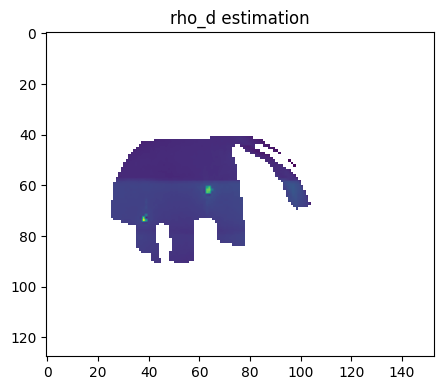

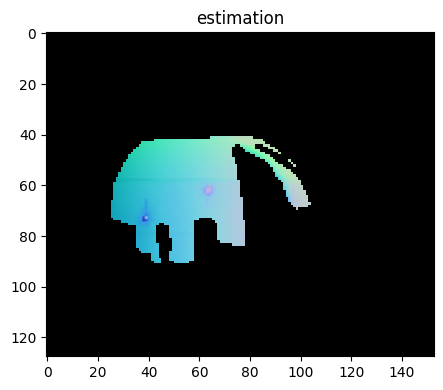

In [9]:
from scipy.optimize import least_squares

image_num = index_list.shape[0]
observed_stokes = np.zeros((image_num,h,w,4))
sun_dir = np.zeros((image_num, 3))
DoLPsmax = np.zeros((image_num))

I_d_est = np.zeros((image_num))
t_d_est = 0
rho_d_est = np.zeros((h,w))
I_zeta_est = 0
n_est = np.zeros((h,w,3))

view = np.array([0,0,-1])
print('zenith: ' + str(zenith))

# get direction of light sources for each pixel position
for i in range(image_num):
    index = index_list[i]
    
    pimg = cv2.imread(IMAGE_PATH + scene_list[index] +'/L.png', cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE).astype(np.float32) /(256*256-1.0)
    pbayer_ = PBayer(pimg)
    observed_stokes[i] = pbayer_.stokes
    
    sun_dir[i] = sun_dir_list[index]
    
    DoLPsmax[i] = DoLPsmax_list[index]

#sampling some pixels to estimate uniform parameters
pixel_num = 0
max_pixel_num = int(np.ceil((h/pixely_interval_1+1)*(w/pixelx_interval_1+1)))
sampled_observed_stokes = np.zeros((image_num, max_pixel_num, 4))
for i in range(0,h,pixely_interval_1):
    for j in range(0,w,pixelx_interval_1):
        if mask[i,j] >= 1:
            sampled_observed_stokes[:,pixel_num,:] = observed_stokes[:,i,j,:]
            pixel_num += 1
sampled_observed_stokes = sampled_observed_stokes[:,0:pixel_num,:]
print("pixel_num : "+str(pixel_num))

sep1 = image_num-1 # I_d
sep2 = sep1+1 # t_d
sep3 = sep2+image_num # I_zata
sep4 = sep3+pixel_num # rho_d
sep5 = sep4+2*pixel_num # normals
# initial value
x0 = np.zeros((sep5))
x0[0:sep1] = I_d_init
x0[sep1:sep2] = t_d_init
x0[sep2:sep3] = I_zeta_init
x0[sep3:sep4] = rho_d_init
x0[sep4:sep5:2] = phi_init
x0[sep4+1:sep5:2] = theta_init

# boundary
lb = np.zeros((sep5))
lb[0:sep1] = 0
lb[sep1:sep2] = t_d_min
lb[sep2:sep3] =0
lb[sep3:sep4] = 0
lb[sep4:sep5:2] = -np.pi
lb[sep4+1:sep5:2] = 0

ub = np.zeros((sep5))
ub[0:sep1] = np.inf
ub[sep1:sep2] = t_d_max
ub[sep2:sep3] = np.inf
ub[sep3:sep4] = np.inf
ub[sep4:sep5:2] = 0
ub[sep4+1:sep5:2] = np.pi
lb_list = lb.tolist()
ub_list = ub.tolist()

ret = least_squares(getResidual_init,x0=x0, bounds=(lb_list,ub_list), 
                    args=(sampled_observed_stokes, refractive_index, sun_dir, DoLPsmax, skyModelParams, zenith), max_nfev=100)
I_d_est[0] = 1
I_d_est[1:image_num] = ret.x[0:sep1]
t_d_est = ret.x[sep1]
I_zeta_est = ret.x[sep2:sep3]
print('I_d: '+str(I_d_est))
print('t_d: '+str(t_d_est))
print('I_zeta: '+str(I_zeta_est))
print('error: '+str(ret.cost))
I_s_est = I_d_est*t_d_est


# estimate normal

# initial value
n_init = np.zeros((h,w,3))
n_init[:,:] = normal.pt2n_x_scalar(phi_init,theta_init)
rho_d_init_matrix = np.ones((h,w))*rho_d_init
# boundary
lb = np.zeros((3))
lb[0] = 0
lb[1] = -np.pi
lb[2] = 0
ub = np.zeros((3))
ub[0] = np.inf
ub[1] = 0
ub[2] = np.pi
lb_list = lb.tolist()
ub_list = ub.tolist()
bounds = (lb_list,ub_list)

n_est, rho_d_est = estimateNormal(step1, pixel_range1, n_init, rho_d_init_matrix, bounds, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, skyModelParams, zenith, mask)

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(rho_d_est[::step1,::step1]*mask[::step1,::step1]),plt.title('rho_d estimation')
plt.show()

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mueller.getNormalImg(n_est[::step1,::step1]) * mask[::step1,::step1,np.newaxis]),plt.title('estimation')
plt.show()

## alternating minimization

iteration: 0
pixel_num : 148671
I_d: [1.         1.40237583]
t_d: 3.4462186435907975
I_zeta: [0.75978473 0.71714389]
error: 1463.1760096450448
i: 0
i: 10
i: 20
i: 30
i: 40
i: 50
i: 60
i: 70
i: 80
i: 90
i: 100
i: 110
i: 120
i: 130
i: 140
i: 150
i: 160
i: 170
i: 180
i: 190
i: 200
i: 210
i: 220
i: 230
i: 240
i: 250
i: 260
i: 270
i: 280
i: 290
i: 300
i: 310
i: 320
i: 330
i: 340
i: 350
i: 360
i: 370
i: 380
i: 390
i: 400
i: 410
i: 420
i: 430
i: 440
i: 450
i: 460
i: 470
i: 480
i: 490
i: 500
i: 510
i: 520
i: 530
i: 540
i: 550
i: 560
i: 570
i: 580
i: 590
i: 600
i: 610
i: 620
i: 630
i: 640
i: 650
i: 660
i: 670
i: 680
i: 690
i: 700
i: 710
i: 720
i: 730
i: 740
i: 750
i: 760
i: 770
i: 780
i: 790
i: 800
i: 810
i: 820
i: 830
i: 840
i: 850
i: 860
i: 870
i: 880
i: 890
i: 900
i: 910
i: 920
i: 930
i: 940
i: 950
i: 960
i: 970
i: 980
i: 990
i: 1000
i: 1010
i: 1020


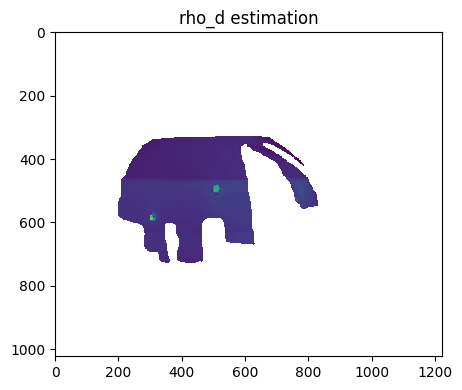

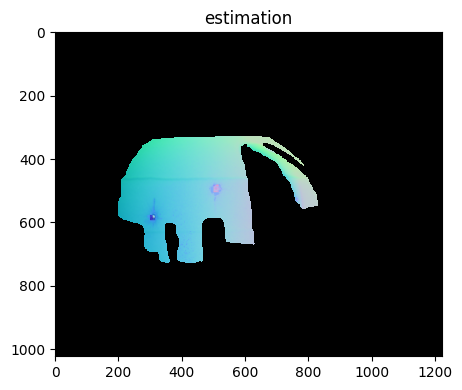

In [10]:
sep1 = image_num-1 # I_d
sep2 = sep1+1 # t_d
sep3 = sep2+image_num # I_zata
# first step boundary
lb_1 = np.zeros((sep3))
lb_1[0:sep1] = 0
lb_1[sep1:sep2] = t_d_min
lb_1[sep2:sep3] =0
ub_1 = np.zeros((sep3))
ub_1[0:sep1] = np.inf
ub_1[sep1:sep2] = t_d_max
ub_1[sep2:sep3] = np.inf
lb_list_1 = lb_1.tolist()
ub_list_1 = ub_1.tolist()

# second step boundary
lb_2 = np.zeros((3))
lb_2[0] = 0 # rho_d
lb_2[1] = -np.pi # phi
lb_2[2] = 0 # theta
ub_2 = np.zeros((3))
ub_2[0] = np.inf
ub_2[1] = 0
ub_2[2] = np.pi
lb_list_2 = lb_2.tolist()
ub_list_2 = ub_2.tolist()
bounds2 = (lb_list_2, ub_list_2)

error = np.zeros((h,w))
for ite in range(0,iteration_num):
    print('iteration: '+str(ite))
    
    # initial value
    x0_1 = np.zeros((sep3))
    x0_1[0:sep1] = I_d_est[1:]
    x0_1[sep1:sep2] = t_d_est
    x0_1[sep2:sep3] = I_zeta_est
    
    #sampling some pixels to estimate uniform parameters
    pixel_num = 0
    max_pixel_num = int(np.ceil((h/pixely_interval_2+1)*(w/pixelx_interval_2+1)))
    sampled_observed_stokes = np.zeros((image_num, max_pixel_num, 4))
    sampled_n_est = np.zeros((max_pixel_num, 3))
    sampled_rho_d_est = np.zeros((max_pixel_num))
    for i in range(0,h,pixely_interval_2):
        for j in range(0,w,pixelx_interval_2):
            if mask[i,j] >= 1:
                sampled_observed_stokes[:,pixel_num,:] = observed_stokes[:,i,j,:]
                sampled_n_est[pixel_num] = n_est[i,j]
                sampled_rho_d_est[pixel_num] = rho_d_est[i,j]
                pixel_num += 1
    sampled_observed_stokes = sampled_observed_stokes[:,0:pixel_num,:]
    sampled_n_est = sampled_n_est[0:pixel_num]
    sampled_rho_d_est = sampled_rho_d_est[0:pixel_num]
    print("pixel_num : "+str(pixel_num))
    
    ret = least_squares(getResidual,x0=x0_1, bounds=(lb_list_1,ub_list_1), 
                        args=(sampled_observed_stokes, sampled_n_est, refractive_index, sun_dir, DoLPsmax, sampled_rho_d_est, skyModelParams, zenith), max_nfev=100)
    
    I_d_est[0] = 1
    I_d_est[1:image_num] = ret.x[0:sep1]
    t_d_est = ret.x[sep1]
    I_zeta_est = ret.x[sep2:sep3]
    print('I_d: '+str(I_d_est))
    print('t_d: '+str(t_d_est))
    print('I_zeta: '+str(I_zeta_est))
    print('error: '+str(ret.cost))
    I_s_est = I_d_est*t_d_est
    
    # estimate normal
    n_est, rho_d_est = estimateNormal(step2[ite], pixel_range2[ite], n_est, rho_d_est, bounds2, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, skyModelParams, zenith, mask)

    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(rho_d_est[::step,::step]*mask[::step,::step]),plt.title('rho_d estimation')
    plt.show()
    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(mueller.getNormalImg(n_est[::step,::step]) * mask[::step,::step,np.newaxis]),plt.title('estimation')
    plt.show()

## show the result

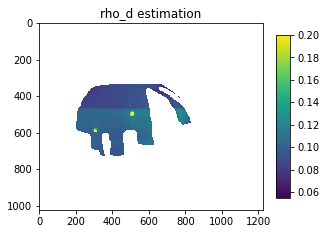

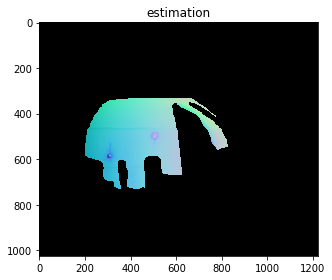

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(rho_d_est[::step,::step]*mask[::step,::step], vmax=0.2),plt.title('rho_d estimation')
plt.colorbar(shrink=0.6,aspect=12)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(mueller.getNormalImg(n_est[::step,::step]) * mask[::step,::step,np.newaxis]),plt.title('estimation')
plt.show()

In [12]:
# save

n_save_file = 'normal_data/ceramic1020_1120_1520'
np.save(n_save_file, n_est)

rhod_save_file = 'rhod_data/ceramic1020_1120_1520'
np.save(rhod_save_file, rho_d_est)
